In [1]:
import zipfile
import os

zip_path = "/content/CASIA-Iris-Interval-20250617T034139Z-1-001.zip"  # Replace with your actual filename
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("unzipped_Iris-Interval")

In [2]:
import os
import shutil
import random

def get_all_images_recursive(class_path):
    images = []
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append(os.path.join(root, file))
    return images

def split_dataset(input_dir, output_dir, train_ratio=0.625, val_ratio=0.25, test_ratio=0.125):
    # Set random seed for reproducibility
    random.seed(42)

    # Clear output directory to prevent duplicate images
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    class_names = os.listdir(input_dir)
    total_images = 0

    # Count total images across all classes
    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        images = get_all_images_recursive(class_path)
        total_images += len(images)
    print(f"Total images in input directory: {total_images}")

    # Split images for each class
    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = get_all_images_recursive(class_path)
        random.shuffle(images)

        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        train_imgs = images[:train_end]
        val_imgs = images[train_end:val_end]
        test_imgs = images[val_end:]

        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img_path in split_imgs:
                img_name = os.path.basename(img_path)
                dst = os.path.join(split_dir, img_name)
                shutil.copy2(img_path, dst)
            print(f"Copied {len(split_imgs)} images to {split_dir}")

input_dataset_folder = "/content/unzipped_Iris-Interval/CASIA-Iris-Interval"
output_dataset_folder = "/content/split_dataset"
split_dataset(input_dataset_folder, output_dataset_folder)

Total images in input directory: 2639
Copied 8 images to /content/split_dataset/train/101
Copied 3 images to /content/split_dataset/val/101
Copied 3 images to /content/split_dataset/test/101
Copied 8 images to /content/split_dataset/train/126
Copied 3 images to /content/split_dataset/val/126
Copied 3 images to /content/split_dataset/test/126
Copied 9 images to /content/split_dataset/train/147
Copied 3 images to /content/split_dataset/val/147
Copied 3 images to /content/split_dataset/test/147
Copied 2 images to /content/split_dataset/train/229
Copied 1 images to /content/split_dataset/val/229
Copied 1 images to /content/split_dataset/test/229
Copied 5 images to /content/split_dataset/train/196
Copied 2 images to /content/split_dataset/val/196
Copied 2 images to /content/split_dataset/test/196
Copied 2 images to /content/split_dataset/train/224
Copied 1 images to /content/split_dataset/val/224
Copied 1 images to /content/split_dataset/test/224
Copied 6 images to /content/split_dataset/tr

In [3]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

In [4]:
mg_height, img_width = (256,256)
batch_size = 16

train_data_dir = r"/content/split_dataset/train"
valid_data_dir = r"/content/split_dataset/val"
test_data_dir = r"/content/split_dataset/test"

In [5]:
import os

def count_images_in_directory(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                total += 1
    return total



# Count and print
print(f" Number of training images: {count_images_in_directory(train_data_dir)}")
print(f" Number of validation images: {count_images_in_directory(valid_data_dir)}")
print(f" Number of test images: {count_images_in_directory(test_data_dir)}")

 Number of training images: 1533
 Number of validation images: 571
 Number of test images: 535


In [6]:
train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical') # set as training data

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical') # set as validation data

Found 1533 images belonging to 240 classes.
Found 571 images belonging to 240 classes.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input  # or use VGG16's preprocess_input

# Define test image data generator
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Then use it here
test_generator = test_datagen.flow_from_directory(
    "/content/split_dataset/test",
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 535 images belonging to 240 classes.


In [8]:
x, y = next(test_generator)
x.shape

(16, 256, 256, 3)

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load ResNet50 with ImageNet weights, excluding top layer
base_model = ResNet50(include_top=False, weights='imagenet')

# Build custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all base model layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile model for initial training
custom_optimizer = Adam(learning_rate=0.0002)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_initial.h5', monitor='val_accuracy', save_best_only=True)

# Initial training
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,  # Initial training epochs
    callbacks=[early_stopping, checkpoint]
)

# Unfreeze selective layers for fine-tuning (last 10 layers, roughly conv5_x block)
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile model with lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for fine-tuning
checkpoint_finetune = ModelCheckpoint('best_model_finetuned.h5', monitor='val_accuracy', save_best_only=True)

# Fine-tuning training
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,  # Fewer epochs for fine-tuning
    callbacks=[early_stopping, checkpoint_finetune]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0347 - loss: 5.6190

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.0351 - loss: 5.6115 - val_accuracy: 0.2224 - val_loss: 4.3034
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2369 - loss: 3.9923

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.2374 - loss: 3.9901 - val_accuracy: 0.4518 - val_loss: 3.0919
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5402 - loss: 2.6081

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.5404 - loss: 2.6069 - val_accuracy: 0.6340 - val_loss: 2.1501
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7303 - loss: 1.6729

96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.7305 - loss: 1.6721 - val_accuracy: 0.7198 - val_loss: 1.5723
Epoch 5/20
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8804 - loss: 1.0475

96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8805 - loss: 1.0463 - val_accuracy: 0.8406 - val_loss: 1.1667
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9436 - loss: 0.6657

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9436 - loss: 0.6655 - val_accuracy: 0.8651 - val_loss: 0.9208
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9723 - loss: 0.4594

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9722 - loss: 0.4592 - val_accuracy: 0.9054 - val_loss: 0.7398
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9828 - loss: 0.3124

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9828 - loss: 0.3123 - val_accuracy: 0.9089 - val_loss: 0.6339
Epoch 9/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9965 - loss: 0.2013

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.9965 - loss: 0.2013 - val_accuracy: 0.9264 - val_loss: 0.5417
Epoch 10/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9961 - loss: 0.1636 - val_accuracy: 0.9212 - val_loss: 0.4975
Epoch 11/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9996 - loss: 0.1179

96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.9995 - loss: 0.1179 - val_accuracy: 0.9352 - val_loss: 0.4429
Epoch 12/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.9969 - loss: 0.0927 - val_accuracy: 0.9264 - val_loss: 0.4138
Epoch 13/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0769

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 1.0000 - loss: 0.0768 - val_accuracy: 0.9370 - val_loss: 0.3732
Epoch 14/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9992 - loss: 0.0570

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.9993 - loss: 0.0570 - val_accuracy: 0.9422 - val_loss: 0.3502
Epoch 15/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0492

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 1.0000 - loss: 0.0492 - val_accuracy: 0.9475 - val_loss: 0.3345
Epoch 16/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 1.0000 - loss: 0.0407 - val_accuracy: 0.9440 - val_loss: 0.3240
Epoch 17/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 1.0000 - loss: 0.0353 - val_accuracy: 0.9440 - val_loss: 0.3149
Epoch 18/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0304

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 1.0000 - loss: 0.0304 - val_accuracy: 0.9510 - val_loss: 0.2973
Epoch 19/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 1.0000 - loss: 0.0258 - val_accuracy: 0.9440 - val_loss: 0.2903
Epoch 20/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0251

96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 1.0000 - loss: 0.0251 - val_accuracy: 0.9545 - val_loss: 0.2793
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9883 - loss: 0.2225

96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 200ms/step - accuracy: 0.9884 - loss: 0.2219 - val_accuracy: 0.9510 - val_loss: 0.3065
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0834

96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 1.0000 - loss: 0.0834 - val_accuracy: 0.9615 - val_loss: 0.3038
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0570

96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 1.0000 - loss: 0.0570 - val_accuracy: 0.9632 - val_loss: 0.2971
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 1.0000 - loss: 0.0453 - val_accuracy: 0.9615 - val_loss: 0.2843
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 1.0000 - loss: 0.0362 - val_accuracy: 0.9615 - val_loss: 0.2716
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 1.0000 - loss: 0.0320 - val_accuracy: 0.9615 - val_loss: 0.2590
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 1.0000 - loss: 0.0275 - val_accuracy: 0.9615 - val_loss: 0.2505
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 0.9632 - val_loss: 0.2409
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 1.0000 - loss: 0.0215 - val_accuracy: 0.9615 - val_loss: 0.2332
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0173

96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.9667 - val_loss: 0.2255


In [10]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 - 5s - 137ms/step - accuracy: 0.9308 - loss: 0.4522

Test accuracy: 0.9308411478996277


In [11]:
!mkdir -p /content/drive/MyDrive/Iris_Model1

In [12]:
model.save('/content/drive/MyDrive/Iris_Model1/ResNet50_Iris3.h5')

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import os
import datetime

def evaluate_model(model_path, test_dir, target_size=(256, 256), output_dir="evaluation_results"):
    """
    Evaluate a trained model on test data with comprehensive metrics and visualizations.
    Includes detailed debugging for confusion matrix issues.
    """
    try:
        # Create output directory
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Load model
        try:
            model = load_model(model_path)
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return

        # Create test data generator with consistent target size
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=target_size,
            batch_size=16,
            class_mode='categorical',
            shuffle=False
        )
        print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes.")

        # Create index-to-class mapping
        class_indices = test_generator.class_indices
        index_to_class = {v: k for k, v in class_indices.items()}
        class_labels = list(class_indices.keys())
        print(f"Class indices: {class_indices}")

        # Evaluate model to get a baseline
        test_loss, test_acc = model.evaluate(test_generator, verbose=2)
        print(f"\nTest accuracy: {test_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}")

        # Make predictions with explicit steps
        test_generator.reset()
        num_samples = test_generator.samples
        predictions = model.predict(test_generator, steps=int(num_samples / test_generator.batch_size), verbose=1)
        predicted_classes = np.argmax(predictions[:num_samples], axis=1)  # Ensure length matches
        true_classes = test_generator.classes[:num_samples]

        # Debugging prints
        print(f"Number of true classes: {len(true_classes)}")
        print(f"Number of predicted classes: {len(predicted_classes)}")
        print(f"Sample predictions: {predicted_classes[:10]}")
        print(f"Sample true classes: {true_classes[:10]}")
        print(f"Max prediction value: {np.max(predictions)}")
        print(f"Min prediction value: {np.min(predictions)}")

        # Verify and adjust lengths
        if len(true_classes) != len(predicted_classes):
            print(f"Warning: Mismatch in lengths - True: {len(true_classes)}, Predicted: {len(predicted_classes)}")
            min_length = min(len(true_classes), len(predicted_classes))
            true_classes = true_classes[:min_length]
            predicted_classes = predicted_classes[:min_length]
        else:
            print("Lengths match successfully")

        # Calculate confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        print(f"Confusion matrix shape: {cm.shape}")
        print(f"Confusion matrix content:\n{cm}")

        # Plot full confusion matrix for first 10 classes
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues',  # Limit to 10x10 for readability
                    xticklabels=class_labels[:10],
                    yticklabels=class_labels[:10])
        plt.title('Confusion Matrix (First 10 Classes)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
        plt.close()

        # Calculate and save classification report
        print("\nClassification Report:")
        print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))
        with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
            f.write(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

        # Save overall metrics
        accuracy = np.mean(predicted_classes == true_classes)
        metrics = {
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'overall_accuracy': accuracy,
            'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(os.path.join(output_dir, 'metrics.txt'), 'w') as f:
            for key, value in metrics.items():
                f.write(f"{key}: {value}\n")

        print(f"\nOverall Accuracy: {accuracy:.4f}")
        print(f"Evaluation results saved in {output_dir}")

    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    model_path = '/content/drive/MyDrive/Iris_Model1/ResNet50_Iris3.h5'
    test_dir = "/content/split_dataset/test"
    evaluate_model(model_path, test_dir, target_size=(256, 256))

Model loaded successfully
Found 535 images belonging to 240 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 535 images belonging to 240 classes.
Class indices: {'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19, '021': 20, '022': 21, '023': 22, '024': 23, '025': 24, '026': 25, '027': 26, '028': 27, '029': 28, '030': 29, '031': 30, '032': 31, '033': 32, '034': 33, '035': 34, '036': 35, '037': 36, '038': 37, '039': 38, '040': 39, '041': 40, '042': 41, '043': 42, '044': 43, '045': 44, '046': 45, '047': 46, '048': 47, '049': 48, '050': 49, '051': 50, '052': 51, '053': 52, '054': 53, '055': 54, '056': 55, '057': 56, '058': 57, '059': 58, '060': 59, '061': 60, '062': 61, '063': 62, '064': 63, '065': 64, '066': 65, '067': 66, '068': 67, '069': 68, '070': 69, '071': 70, '072': 71, '073': 72, '074': 73, '075': 74, '076': 75, '077': 76, '078': 77, '079': 78, '080': 79, '081': 80, '082': 81, '083': 82, '084': 83, '085': 84, '086': 85, '087'

    epoch  accuracy  val_accuracy      loss  val_loss  learning_rate
0       1  0.056099      0.222417  5.254959  4.303449        0.00001
1       2  0.286367      0.451839  3.777846  3.091942        0.00001
2       3  0.562296      0.633976  2.497107  2.150075        0.00001
3       4  0.746902      0.719790  1.596693  1.572341        0.00001
4       5  0.882583      0.840630  0.987423  1.166683        0.00001
5       6  0.939335      0.865149  0.647326  0.920826        0.00001
6       7  0.967384      0.905429  0.441616  0.739763        0.00001
7       8  0.984344      0.908932  0.299253  0.633900        0.00001
8       9  0.993477      0.926445  0.206317  0.541668        0.00001
9      10  0.995434      0.921191  0.157372  0.497526        0.00001
10     11  0.999348      0.935201  0.117427  0.442861        0.00001
11     12  0.998043      0.926445  0.090570  0.413806        0.00001
12     13  1.000000      0.936953  0.074385  0.373226        0.00001
13     14  0.999348      0.942207 

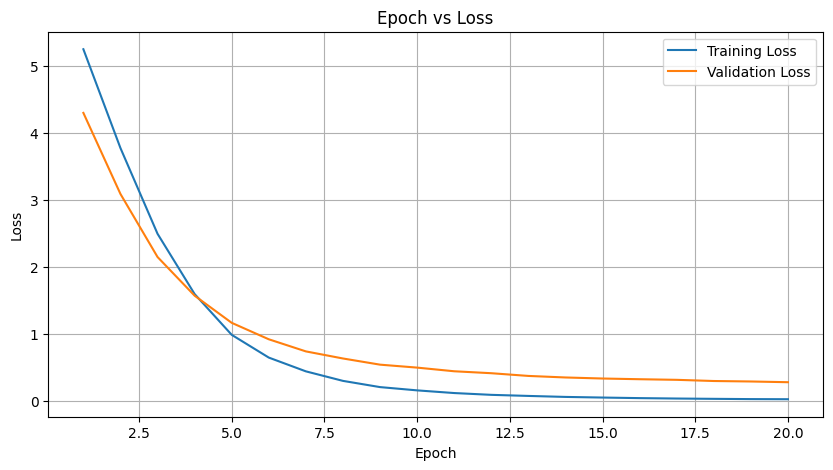

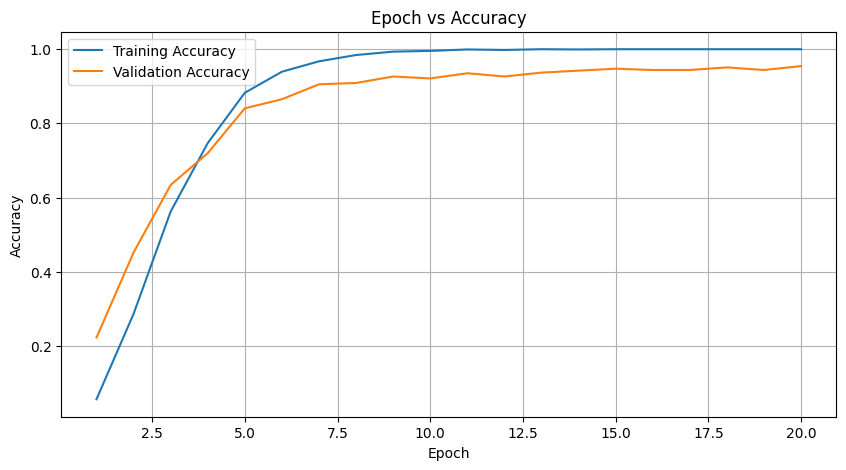

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a results dictionary from history object
results = {
    'epoch': list(range(1, len(history.history['accuracy']) + 1)),
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'learning_rate': [float(tf.keras.backend.get_value(model.optimizer.learning_rate))] * len(history.history['accuracy'])
}

# Create a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save to CSV (optional)
results_df.to_csv("evaluation_results/training_metrics_table.csv", index=False)

# Plot Epoch vs. Loss
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['loss'], label='Training Loss')
plt.plot(results['epoch'], results['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.savefig("evaluation_results/epoch_vs_loss.png")
plt.show()

# Plot Epoch vs. Accuracy
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['accuracy'], label='Training Accuracy')
plt.plot(results['epoch'], results['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("evaluation_results/epoch_vs_accuracy.png")
plt.show()